In [24]:
from sympy import *
from sympy import init_printing
init_printing()
def ll(a, b):
    return (a*b) / (a + b)

In [10]:
# Problem 2: Resistance looking into drain of source-degenerated NMOS (re-derivation as a test)
i1,i2,i3 = symbols("i1 i2 i3")
vtest, vs, gm, Rs, ro, itest = symbols("v_{test} V_s g_m R_s r_o, i_{test}")
sol = nonlinsolve([
    i1 + i2 - i3,
    itest + i1 + i2,
    i2 - (vtest - vs)/ro,
    i1 + gm*vs,
    i3 - vs/Rs
], [i1, i2, i3, vtest, vs, itest])
itest = sol.args[0][5]
rout = vtest / -itest
display(rout.simplify())

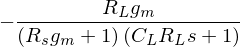

In [15]:
# Problem 2a: Naive Gain of CS-amp with degeneration and complex R_L || C_L load (ignoring C_gs)
s, RL, CL = symbols("s R_L C_L")
ZL = RL / (1 + s*RL*CL)
av = - (gm * ZL) / (1 + gm*Rs)
display(av.simplify())

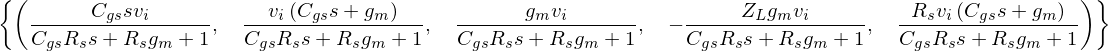

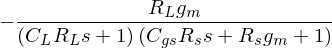

- \frac{R_{L} g_{m}}{\left(C_{L} R_{L} s + 1\right) \left(C_{gs} R_{s} s + R_{s} g_{m} + 1\right)}


In [32]:
# Problem 2a: Proper gain derivation (considering C_gs)
s, RL, CL, ZL, Cgs, Rs, gm = symbols("s R_L C_L Z_L C_{gs} R_s g_m")
igate, isource, idrain = symbols("i_g i_s i_d")
vs, vd, vi = symbols("v_s v_d v_i")
sol = nonlinsolve([
    igate - ((vi - vs) / (1 / (s*Cgs))),
    isource - (vs / Rs),
    idrain - gm*(vi - vs),
    -vd - idrain*ZL,
    isource - igate - idrain
], [igate, isource, idrain, vd, vs])
display(sol)
vd_sol = sol.args[0][3]
gain = vd_sol / vi
ZL_sol = ll(CL, RL)
ZL_sol = ZL_sol.subs(CL, (1 / (s*CL))).simplify()
gain = gain.subs(ZL, ZL_sol).simplify()
display(gain)
print(latex(gain))

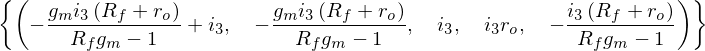

In [38]:
i1,i2,i3 = symbols("i1 i2 i3")
vtest, vx, gm, Rf, ro = symbols("V_{test} V_x g_m R_f r_o")
sol = nonlinsolve([
    i1 - (vtest - vx)/Rf,
    i2 - gm*vtest,
    i3 - (vx / ro),
    i1 - i2 - i3
], [i1, i2, i3, vx, vtest])
display(sol)

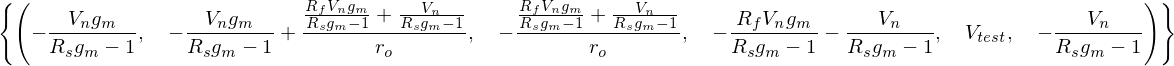

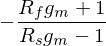

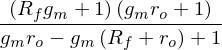

In [50]:
i1,i2,i3 = symbols("i1 i2 i3")
vtest, vx, Vgs, vn, gm, Rf, ro = symbols("V_{test} V_x V_{gs} V_n g_m R_f r_o")
sol = nonlinsolve([
    Vgs - i1*Rs - vn,
    i1 - i2 - i3,
    (vx - Vgs)/Rf - i1,
    i1 - gm*Vgs,
    i3 - vx/ro
], [i1, i2, i3, vx, vtest, Vgs])
display(sol)
Rs_noise_gain = sol.args[0][3] / vn
Rs_noise_gain = Rs_noise_gain.simplify()
Rs_noise_gain_match = Rs_noise_gain.subs(Rs, (ro + Rf) / (1 + ro*gm))
display(Rs_noise_gain)
display(Rs_noise_gain_match.simplify())